## Outline
1. Import libraries and initialise global variables
2. Data preprocessing
    - Load in dataset
    - Buffered prefetching
    - Data augmentation
    - Rescaling
3. Load base model
    - MobileNet V3
    - DenseNet
    - ResNet50 201
4. Create complete model
5. Train model
6. Findings and results

In [1]:
import tensorflow as tf

# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gen_results import gen_save_cr_cm # Load test results
import pandas as pd
import seaborn as sns

import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import model_create_save
from tqdm import tqdm
from pathlib import Path

In [4]:
# Initialise sets
BATCH_SIZE = 64
EPOCHS = 500
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
LABELS = ["female", "male"]

In [10]:
new_v = [5]
# @TODO Allow history to create own set 1 file if doesn't exist

In [14]:
def gen_models_all_sets(EPOCHS=EPOCHS):
    for set_no in tqdm(new_v, "Loading models..."):
        # Set number of epochs
        model_create_save.set_epochs(EPOCHS)
        # Set 1 to ...
        # target = 'preprocessing/cv_datasets/set{}'.format(set_no) + "/"
        target = 'preprocessing/cv_datasets_debiased/set{}'.format(set_no) + "/"
        model_create_save.reset(target, EPOCHS)
        print("Training...")
        model_create_save.find_best_weights_and_history(set_no)
        print("Saving...")
        print("--------------------------------")

In [16]:
gen_models_all_sets()

Loading models...:   0%|          | 0/1 [00:00<?, ?it/s]

Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23063 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/500
721/721 [==============================] - 38s 50ms/step - loss: 5.9861 - accuracy: 0.7391 - val_loss: 0.8925 - val_accuracy: 0.7879
Epoch 2/500
721/721 [==============================] - 35s 49ms/step - loss: 0.6950 - accuracy: 0.7980 - val_loss: 0.4985 - val_accuracy: 0.7940
Epoch 3/500
721/721 [==============================] - 35s 49ms/step - loss: 0.4430 - accuracy: 0.8113 - val_loss: 0.4582 - val_accuracy: 0.7984
Epoch 4/500
721/721 [==============================] - 35s 49ms/step - loss: 0.4000 - accuracy: 0.8154 - val_loss: 0.4340 - val_accuracy: 0.7973
Epoch 5/500
721/721 [==============================] - 35s 49ms/step - loss: 0.3828 - accuracy: 0.8222 - val_loss: 0.4508 - val_accuracy: 0.7973
Epoch 6/500
721/721 [==============================] - 35s 49ms/s

Loading models...: 100%|██████████| 1/1 [12:38:56<00:00, 45536.16s/it]

Saving...
--------------------------------


# Model Analysis

## Plot Accuracy and Loss graphs over 50 epochs

In [201]:
def plot_acc_loss_graph(data, key, history, mobile_type):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc += history['accuracy']
    val_acc += history['val_accuracy']

    loss += history['loss']
    val_loss += history['val_loss']
    
    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(wspace=0.5, hspace= 0.4)
    
    plt.subplot(212)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(222)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(221)
    cf_matrix = data[key]
    kw = key[3:].split('_')
    # Update title
    f = kw[0]
    if f == 'mobile':
        kw[0] = "MobileNet"
    elif f == 'dense':
        kw[0] = 'DenseNet'
    elif f == 'res':
        kw[0] = 'ResNet50'
    
    if kw[1] == 'all':
        kw[1] = 'both'
        
    kw = kw[0]
    cf_matrix = np.array(cf_matrix)
    
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = map(round, cf_matrix.flatten())
    group_percentages = (
        f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
    )
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"
    labels = np.asarray(
        ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
    ).reshape(2, 2)

    plt.suptitle(kw, fontsize = 20, ha='center')
    
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(
        df_cm,
        annot=labels,
        annot_kws={"size": 15},
        cmap="YlOrBr",
        fmt="",
        xticklabels=LABELS,
        yticklabels=LABELS,
    )
    sns.set_style("darkgrid")
    
    # plt.savefig(f'stats_diagrams/%s_acc_loss_graph.png' % mobile_type)
    plt.show()

In [202]:
# Load histories
baseline_fp = "(5)_early_stopping_20"
debiased_fp = "(7)_debiased_50"

with open(f'timeline/%s/history/set10/model_tl_history_mobile_set10.json' % debiased_fp) as f:
    history_mobile = json.load(f)
with open(f'timeline/%s/history/set10/model_tl_history_dense_set10.json' % debiased_fp) as f:
    history_dense = json.load(f)
with open(f'timeline/%s/history/set10/model_tl_history_res_set10.json' % debiased_fp) as f:
    history_res = json.load(f)

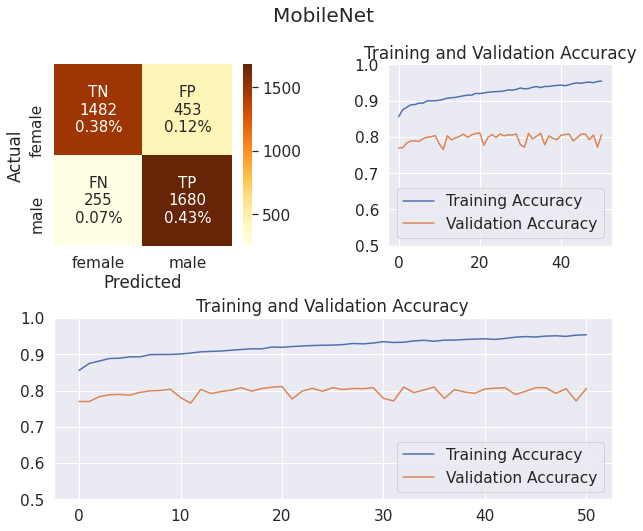

In [203]:
# Accuracy and Loss graphs for MobileNet
plot_acc_loss_graph(data_mobile_both, "cm_mobile_bothg", history_mobile, 'mobile_debiased')

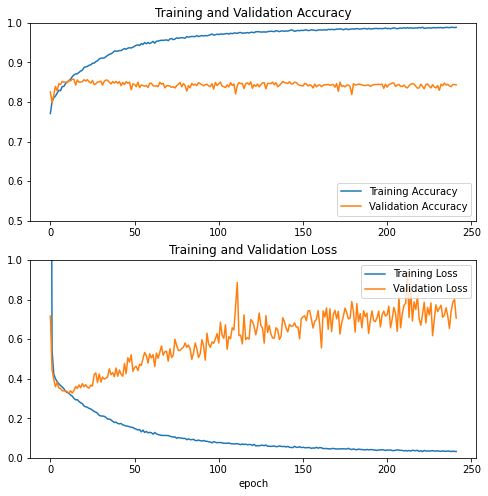

In [32]:
# Accuracy and Loss graphs for DenseNet
plot_acc_loss_graph(history_dense, 'dense_debiased')

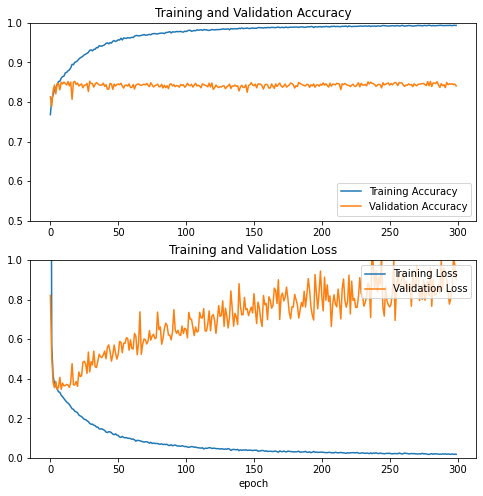

In [33]:
# Accuracy and Loss graphs for ResNet50
plot_acc_loss_graph(history_res, 'res_debiased')

## Confusion Matrix

In [2]:
def get_all_models(set_no, best_w_fp="best_weights/"):
    # Where will we be loading the models from?
    target = best_w_fp + "set" + str(set_no) + "/"
    mobilenet = tf.keras.models.load_model(target + 'model_tl_best_weights_mobile_set{}.h5'.format(str(set_no)))
    densenet = tf.keras.models.load_model(target + 'model_tl_best_weights_dense_set{}.h5'.format(str(set_no)))
    resnet = tf.keras.models.load_model(target + 'model_tl_best_weights_res_set{}.h5'.format(str(set_no)))
    all_models = [mobilenet, densenet, resnet]
    return all_models
    
def gen_result_for_sets(all_models, original, target, test_type="all_four"):
    """
    Call this function to generate Classification Reports and 
    Confusion Matrix results
    
    test_type : str
        Determines what test sets do we want to test the model on
    """
    if test_type == "all_four" or test_type == "all":
        # ============================================================================
        # For all testing sets
        # ============================================================================
        # Classification reports and confusion matrices for MobileNet
        cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation='all', gender=None) # Both
        # Classification reports and confusion matrices for DenseNet
        cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation='all', gender=None) # Both
        # Classification reports and confusion matrices for ResNet
        cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation='all', gender=None) # Both
    
    if test_type == "all_four" or test_type == "ori":
        # ============================================================================
        # For all testing set with no perturbations
        # ============================================================================
        # Classification reports and confusion matrices for MobileNet
        cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation='ori') # Both
        # Classification reports and confusion matrices for DenseNet
        cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation='ori') # Both
        # Classification reports and confusion matrices for ResNet
        cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation='ori') # Both

    if test_type == "all_four" or test_type == "glasses":
        # ============================================================================
        # For all testing set with glasses filter
        # ============================================================================
        # Classification reports and confusion matrices for MobileNet
        cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation='glasses') # Both
        # Classification reports and confusion matrices for DenseNet
        cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation='glasses') # Both
        # Classification reports and confusion matrices for ResNet
        cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation='glasses') # Both

    if test_type == "all_four" or test_type == "mask":
        # ============================================================================
        # For all testing set with masked filter
        # ============================================================================
        # Classification reports and confusion matrices for MobileNet
        cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation='masked') # Both
        # Classification reports and confusion matrices for DenseNet
        cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation='masked') # Both
        # Classification reports and confusion matrices for ResNet
        cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation='masked') # Both

    if test_type == "all_four" or test_type == "makeup":
        # ============================================================================
        # For all testing set with makeup filter
        # ============================================================================
        # Classification reports and confusion matrices for MobileNet
        cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation='makeup') # Both
        # Classification reports and confusion matrices for DenseNet
        cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation='makeup') # Both
        # Classification reports and confusion matrices for ResNet
        cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation='makeup') # Both

In [17]:
def gen_cr_cm_results(test_type="all_four", original_folder = "preprocessing/cv_datasets/", target_folder = "cr_cm_results/"):
    """
    Generates cr_cm_results
    """
    new_v = [5]
    # @TODO: For clarity, change to iterate through Set 1 - 4
    for i in tqdm(range(len(new_v)), "Generating results..."):
        set_no = new_v[i]
        # Where is it coming from?
        original = original_folder + "set" + str(set_no) + "/"
        # Where do you want to store the results?
        target = target_folder + "set" + str(set_no) + "/"
        # Make new directory if empty
        Path(target).mkdir(parents=True, exist_ok=True)  
        # Grab all models, MobileNet, DenseNet, ResNet50
        all_models = get_all_models(set_no)
        # Pray
        gen_result_for_sets(all_models, original, target, test_type=test_type)

In [43]:
def load_metrics(model_type, target_folder,
                 perturbation='ori', gender='bothg'):
    """
    Loads in results from folder fyp-ma-13/fyp-models/cr_cm_results
    
    model_type : str
        Either 'mobile' (MobileNet), 'dense' (DenseNet) or 'res' (ResNet50)
    target_folder : str
        Target folder name from timeline 
    perturbation: str
        Either 'ori', 'masked', 'glasses', 'make_up' or 'all'
    """
    assert perturbation in ['ori', 'masked', 'glasses', 'make_up']
    
    with open("timeline/{}/cr_cm_results/set10/cr_cm_{}_{}_{}".format(target_folder, model_type, perturbation, gender)) as json_file:
        data = json.load(json_file)
        data = json.loads(data)
    return data

In [44]:
# gen_cr_cm_results(test_type="ori", original_folder = "preprocessing/cv_datasets_debiased/", target_folder = "cr_cm_results/")

In [122]:
# Load results

# Both
data_mobile_both = load_metrics('mobile', debiased_fp)
data_dense_both = load_metrics('dense', debiased_fp)
data_res_both = load_metrics('res', debiased_fp)

# Findings
- Makeup improves accuracy when predicting females
- Makeup degrades accuracy of male classification quite significantly
- Masks generally degrade accuracy
- Masks degrade the accuracy of female classification harder compared to male

## Display confusion matrices

In [162]:
def plot_cm(data, key):
    """
    Plots confusion matrix 
    """
    cf_matrix = data[key]
    kw = key[3:].split('_')
    # Update title
    f = kw[0]
    if f == 'mobile':
        kw[0] = "MobileNet"
    elif f == 'dense':
        kw[0] = 'DenseNet'
    elif f == 'res':
        kw[0] = 'ResNet50'
    
    if kw[1] == 'all':
        kw[1] = 'both'
        
    kw = kw[0]
    cf_matrix = np.array(cf_matrix)
    f, ax = plt.subplots(nrows = 1, ncols = 1, sharex=True, figsize=(7, 5))
    
    # ...
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = map(round, cf_matrix.flatten())
    group_percentages = (
        f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
    )
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"
    labels = np.asarray(
        ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
    ).reshape(2, 2)

    plt.suptitle(kw, fontsize = 20, ha='center')
    
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(
        df_cm,
        annot=labels,
        annot_kws={"size": 15},
        cmap="YlOrBr",
        fmt="",
        xticklabels=LABELS,
        yticklabels=LABELS,
    )
    sns.set_style("darkgrid")
    # plt.savefig('stats_diagrams/%s_debiased.png' % key)
    # plt.show()

### Both

In [209]:
data_mobile_both['cr_mobile_bothg'].split("\n")

['              precision    recall  f1-score   support',
 '',
 '           0       0.85      0.77      0.81      1935',
 '           1       0.79      0.87      0.83      1935',
 '',
 '    accuracy                           0.82      3870',
 '   macro avg       0.82      0.82      0.82      3870',
 'weighted avg       0.82      0.82      0.82      3870',
 '']

In [222]:
def calculate_sum_cm(cm):
    res = 0
    for i in data_mobile_both['cm_mobile_all']:
        res += sum(i)
    return res

def calculate_acc_cm(cm):
    tot = calculate_sum_cm(cm)
    tn = cm[0][0]
    tp = cm[1][1]
    return ((tn+tp)/tot)*100

def calculate_female_acc(cm):
    female_row = cm[0]
    return (female_row[0] / (female_row[0] + female_row[1]))*100
    
def calculate_male_acc(cm):
    male_row = cm[1]
    return (male_row[1] / (male_row[0] + male_row[1]))*100

def calculate precision(cm):
    return 

In [245]:
data = {}
cm = data_mobile_both['cm_mobile_bothg']
data['Male Accuracy'] = round(calculate_male_acc(cm), 2)
data['Female Accuracy'] = round(calculate_female_acc(cm), 2)
data['Precision'] = 0.7
data['Recall'] = 0.5
data['Gender Bias Index'] = data['Female Accuracy'] - data['Male Accuracy']
df = pd.DataFrame(data, index=["Score"]).T

In [246]:
df

,Score
Male Accuracy,86.82
Female Accuracy,76.59
Precision,0.70
Recall,0.50
Gender Bias Index,-10.23


|========================================================|


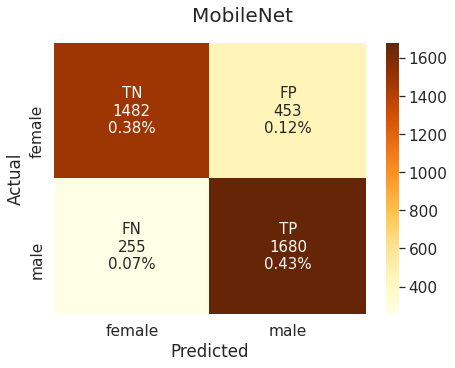

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1935
           1       0.79      0.87      0.83      1935

    accuracy                           0.82      3870
   macro avg       0.82      0.82      0.82      3870
weighted avg       0.82      0.82      0.82      3870

|========================================================|


In [124]:
print('|========================================================|')
plot_cm(data_mobile_both, 'cm_mobile_bothg')
print('+--------------------------------------------------------+')
print(data_mobile_both['cr_mobile_bothg'])
print('|========================================================|')

|========================================================|


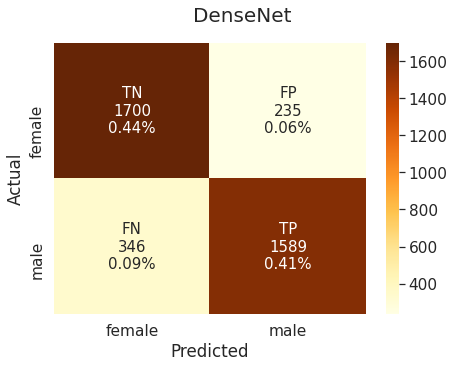

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1935
           1       0.87      0.82      0.85      1935

    accuracy                           0.85      3870
   macro avg       0.85      0.85      0.85      3870
weighted avg       0.85      0.85      0.85      3870

|========================================================|


In [125]:
print('|========================================================|')
plot_cm(data_dense_both, 'cm_dense_bothg')
print('+--------------------------------------------------------+')
print(data_dense_both['cr_dense_bothg'])
print('|========================================================|')

|========================================================|


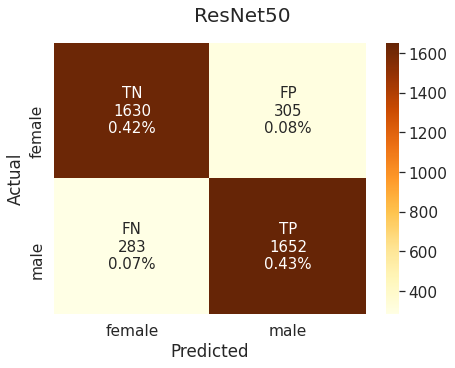

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1935
           1       0.84      0.85      0.85      1935

    accuracy                           0.85      3870
   macro avg       0.85      0.85      0.85      3870
weighted avg       0.85      0.85      0.85      3870

|========================================================|


In [126]:
print('|========================================================|')
plot_cm(data_res_both, 'cm_res_bothg')
print('+--------------------------------------------------------+')
print(data_res_both['cr_res_bothg'])
print('|========================================================|')

### Male

## Single Predictions